# Nutrient analysis of global fisheries II

In [1]:
# Import python packages
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import theano as T
import theano.tensor as tt
from pymc3.backends import SQLite
import seaborn as sns
import scipy as sp
import matplotlib as mp
import arviz as az
import pdb

In [2]:
# Helper functions
def indexall(L):
    poo = []
    for p in L:
        if not p in poo:
            poo.append(p)
    Ix = np.array([poo.index(p) for p in L])
    return poo,Ix

# Helper functions
def indexall_B(L,B):
    poo = []
    for p in L:
        if not p in poo:
            poo.append(p)
    Ix = np.array([poo.index(p) for p in L])
    a, b = poo.index(B), 0
    poo[b], poo[a] = poo[a], poo[b]
    
    Ix[Ix==b] = -1
    Ix[Ix==a] = 0
    Ix[Ix==-1] = a
    return poo,Ix

def subindexall(short,long):
    poo = []
    out = []
    for s,l in zip(short,long):
        if not l in poo:
            poo.append(l)
            out.append(s)
    return indexall(out)

match = lambda a, b: np.array([ b.index(x) if x in b else None for x in a ])
grep = lambda s, l: np.array([i for i in l if s in i])

# Function to standardize covariates
def stdize(x):
    return (x-np.mean(x))/(2*np.std(x))

# Coefficient of variation
cv =  lambda x: np.var(x) / np.mean(x)

In [3]:
def pairplot_divergence(trace, basevar, targetvar, ax=None, divergence=True, color='C3', divergence_color='C2'):
    #theta = trace.get_values(varname=basevar, combine=True)[:, 0]
    theta = trace.get_values(varname=basevar, combine=True)
    logtau = trace.get_values(varname=targetvar, combine=True)
    if not ax:
        _, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.plot(theta, logtau, 'o', color=color, alpha=.5)
    if divergence:
        divergent = trace['diverging']
        ax.plot(theta[divergent], logtau[divergent], 'o', color=divergence_color)
    ax.set_xlabel(basevar)
    ax.set_ylabel(targetvar)
    ax.set_title('scatter plot between log('+targetvar+') and '+basevar);
    return ax

# A small wrapper function for displaying the MCMC sampler diagnostics as above
def report_trace(trace,basevar,targetvar,logscale=False):
    # plot the trace of log(tau)
    pm.traceplot({targetvar: trace.get_values(varname=targetvar, combine=False)});

    # plot the estimate for the mean of log(τ) cumulating mean
    if logscale:
        logtau = np.log(trace[targetvar])
    else:
        logtau = trace[targetvar]
    mlogtau = [np.mean(logtau[:i]) for i in np.arange(1, len(logtau))]
    plt.figure(figsize=(15, 4))
    #plt.axhline(0.7657852, lw=2.5, color='gray')
    plt.plot(mlogtau, lw=2.5)
    plt.ylim(0, 2)
    plt.xlabel('Iteration')
    plt.ylabel('MCMC mean of log('+targetvar+')')
    plt.title('MCMC estimation of log('+targetvar+')')
    plt.show()

    # display the total number and percentage of divergent
    divergent = trace['diverging']
    print('Number of Divergent %d' % divergent.nonzero()[0].size)
    divperc = divergent.nonzero()[0].size / len(trace) * 100
    print('Percentage of Divergent %.1f' % divperc)

    # scatter plot between log(tau) and theta[0]
    # for the identifcation of the problematic neighborhoods in parameter space
    pairplot_divergence(trace,basevar,targetvar);

 Check how MvNormal pdfs change with spp dimension

In [11]:
# Correlation matricies
Cmat1 = np.array([[0,0.3,0.7],[0.3,0,0.5],[0.7,0.5,0]])
np.fill_diagonal(Cmat1,1)
Cmat2 = np.array([[0,0.3,0.7,0.1],[0.3,0,0.5,0.25],[0.7,0.5,0,0.8],[0.1,0.25,0.8,0]])
np.fill_diagonal(Cmat2,1)
# Variance
var1 = np.diag(np.ones(3)*2.3)
var2 = np.diag(np.ones(4)*2.3)

# Covariance matricies
Cov1 = np.matrix.dot(Cmat1,var1,Cmat1)
Cov2 = np.matrix.dot(Cmat2,var2,Cmat2)


In [30]:
# Data
x1 = np.array([1.3,1.6,-0.2])
x2 = np.array([1.3,1.6,-0.2,0.5])

In [52]:
simx1 = sp.stats.multivariate_normal.rvs(x1,Cov1,10000)
simx2 = sp.stats.multivariate_normal.rvs(x2,Cov2,10000)


In [53]:
simx2[:, :3].mean(axis=0)

array([ 1.26947945,  1.61741755, -0.21388531])

In [54]:
simx1.mean(axis=0)

array([ 1.29473405,  1.60372242, -0.20887489])

In [55]:
?sp.stats.multivariate_normal

## Import data

In [4]:
# Nutritional data
ndata = pd.read_excel('Nutrient_data.xlsx')
# Traits data
tdata = pd.read_excel('Traits_all.xlsx')

In [5]:
# Subset ndata
#ndata = ndata.iloc[:100]

In [6]:
# Add traits information to nutritional dataframe
indx = match(ndata.Species_from_search.unique(),list(tdata.species_traits_all.values))
rindx = match(ndata.Species_from_search,list(ndata.Species_from_search.unique()))

# Traits to port over
tmp = ['Class', 'Order', 'Family','Genus_1', 'DemersPelag',
       'EnvTemp', 'DepthRangeDeep', 'trophic_level', 'Feeding_path', 'LMax',
       'BodyShapeI', 'K', 'tm']
# Port over
for trait in tmp:
    ndata[trait] = tdata[trait].values[indx][rindx]

ndata.head()

,ID_no,Species_from_search,Protein_Replicates,Protein_Value_perc,Protein_Variance,Zn_Replicates,Zn_Value,Zn_Variance,Ca_Replicates,Ca_Value,...,Genus_1,DemersPelag,EnvTemp,DepthRangeDeep,trophic_level,Feeding_path,LMax,BodyShapeI,K,tm
0,A_3,Merluccius_merluccius,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Merluccius,demersal,temperate,1075.0,4.40,pelagic,140.0,elongate,0.148,4.199469
1,A_4,Scomber_scombrus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Scomber,pelagic_neritic,temperate,1000.0,3.60,pelagic,60.0,fusiform,0.262,2.636997
2,A_38,Scomber_scombrus,NaN,NaN,NaN,11,0.8090,NaN,NaN,NaN,...,Scomber,pelagic_neritic,temperate,1000.0,3.60,pelagic,60.0,fusiform,0.262,2.636997
3,A_39,Merluccius_gayi_gayi,NaN,NaN,NaN,11,0.1787,NaN,NaN,NaN,...,Merluccius,pelagic_oceanic,polar_deep,500.0,4.26,pelagic,87.0,fusiform,0.120,5.100000
4,A_40,Engraulis_encrasicolus,NaN,NaN,NaN,11,0.7041,NaN,NaN,NaN,...,Engraulis,pelagic_neritic,subtropical,400.0,3.12,pelagic,20.0,elongate,1.000,1.000000


In [7]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [8]:
ndata.head()

,ID_no,Species_from_search,Protein_Replicates,Protein_Value_perc,Protein_Variance,Zn_Replicates,Zn_Value,Zn_Variance,Ca_Replicates,Ca_Value,Ca_Variance,Fe_Replicates,Fe_Value,Fe_Variance,Se_Replicates,Se_Value,Se_Variance,P_Replicates,P_Value,P_Variance,Mg_Replicates,Mg_Value,Mg_Variance,VitA_Replicates,VitA_Value,VitA_Variance,VitB12_Replicates,VitB12_Value,VitB12_Variance,O3_Replicates,O3_Value,O3_Variance,Unnamed: 32,Form_Clean,Search,Year,GeographicLocation_Cleaned,Family,Prep,Protein_prep,Minerals_prep,Vitamin_prep,FA_prep,Protein_Sample_Weight,Zn_Sample_Weight,Ca_Sample_Weight,Fe_Sample_Weight,Se_Sample_Weight,P_Sample_Weight,Mg_Sample_Weight,VitA_Sample_Weight,VitB12_Sample_Weight,O3_Sample_Weight,Class,Order,Genus_1,DemersPelag,EnvTemp,DepthRangeDeep,trophic_level,Feeding_path,LMax,BodyShapeI,K,tm
0,A_3,Merluccius_merluccius,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,muscle,WOS,2014.0,Italy,Merlucciidae,wet,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Actinopterygii,Gadiformes,Merluccius,demersal,temperate,1075.0,4.40,pelagic,140.0,elongate,0.148,4.199469
1,A_4,Scomber_scombrus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,208.0,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,muscle,WOS,2014.0,Italy,Scombridae,wet,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Actinopterygii,Perciformes,Scomber,pelagic_neritic,temperate,1000.0,3.60,pelagic,60.0,fusiform,0.262,2.636997
2,A_38,Scomber_scombrus,NaN,NaN,NaN,11,0.8090,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11,22.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,muscle,WOS,2013.0,Spain,Scombridae,wet,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Actinopterygii,Perciformes,Scomber,pelagic_neritic,temperate,1000.0,3.60,pelagic,60.0,fusiform,0.262,2.636997
3,A_39,Merluccius_gayi_gayi,NaN,NaN,NaN,11,0.1787,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11,13.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,muscle,WOS,2013.0,Spain,Merlucciidae,wet,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Actinopterygii,Gadiformes,Merluccius,pelagic_oceanic,polar_deep,500.0,4.26,pelagic,87.0,fusiform,0.120,5.100000
4,A_40,Engraulis_encrasicolus,NaN,NaN,NaN,11,0.7041,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11,6.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,muscle,WOS,2013.0,Spain,Engraulidae,wet,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Actinopterygii,Clupeiformes,Engraulis,pelagic_neritic,subtropical,400.0,3.12,pelagic,20.0,elongate,1.000,1.000000


### Datasets

In [9]:
Nutrients = ['Protein', 'Zinc', 'Iron', 'Calcium', 'Omega-3', 'Vitamin_A', 'Selenium']
Nkeys = ['Protein_Value_perc', 'Zn_Value', 'Fe_Value', 'Ca_Value', 'O3_Value', 'VitA_Value', 'Se_Value']
nnutrients = len(Nutrients)

In [10]:
# Sample sizes for each nutrient
[sum(np.isnan(ndata[n].values)==False) for n in Nkeys]

[627, 196, 173, 170, 176, 69, 134]

## ======= Loop over nutrients ========= #

In [11]:
i = 3
nut = Nutrients[i]
nut

'Calcium'

In [12]:

# Response
var = Nkeys[i]
Y_ = ndata[var].values


In [13]:
len(Y_)

932

In [14]:
# Units
#'Protein' - g/100g OK
#'Zinc' - mg/100g ---> multiply by 10
#'Iron' - mg/100g ---> multiply by 10
#'Calcium' - mg/100g OK
#'Omega-3': - g/100g ----> multiply by 10
#'Vitamin_A' - μg/100g OK
#'Selenium' - μg/100g OK


# Response
var = Nkeys[i]
Y_ = ndata[var].values

# NA Filter
indx = np.isfinite(Y_)
### ZEROS Filter
if nut in ['Selenium', 'Calcium']:
    indx = indx*(Y_>0)
    
### Protein beyond 60% Filter
if nut in ['Protein']:
    indx = indx*(Y_<60)
    
### Zinc beyond 11 Filter
#if nut in ['Zinc']:
#    indx = indx*(Y_<10)
    
### Omega-3 beyond 610 Filter
if nut in ['Omega-3']:
    indx = indx*(Y_<10)

# Remove non-useful data
Y_ = Y_[indx]

# Unit conversions for better models
if nut in ['Omega-3']:
    Y_ = Y_*10

    
# Log-scale
Ylog = np.log(Y_+1)

# Observation scale
Y = Y_
# Filter dataframe
tmpdata = ndata[indx]

# Index for orders
Order,Io = subindexall(tmpdata.Order.values, tmpdata['Species_from_search'].values)
nord = len(Order)

# Index for species
spxs = list(tmpdata['Species_from_search'].values)
sindx = np.array([spxs.index(s) for s in np.unique(spxs)])

# Species-level covariates
Habitat,Ih = subindexall(tmpdata['DemersPelag'].values, tmpdata['Species_from_search'].values)
nhabs = len(Habitat)
Climate,Ic = subindexall(tmpdata['EnvTemp'].values, tmpdata['Species_from_search'].values)
nclim = len(Climate)
MaxDepth = np.log(tmpdata['DepthRangeDeep'].values)[sindx]
TL = tmpdata['trophic_level'].values[sindx]
FeedPath, Ifp = indexall(tmpdata['Feeding_path'].values[sindx])
nfp = len(FeedPath)
LMax = np.log(tmpdata['LMax'].values)[sindx]
Body,Ib = subindexall(tmpdata['BodyShapeI'].values, tmpdata['Species_from_search'].values)
nbod = len(Body)
K = tmpdata['K'].values[sindx]
tm = np.log(tmpdata['tm'].values)[sindx]

# Nussiance parameters
Form,If = indexall(tmpdata['Form_Clean'].values)
nform = len(Form)
Prep,Ip = indexall(tmpdata['Prep'].values)
nprep = len(Prep)
Search,Is = indexall(tmpdata['Search'].values)
nsearch = len(Search)


In [15]:
FeedPath

['benthic', 'pelagic']

In [16]:
# Phylogentic distance matrix
pdata = pd.read_csv('mean_phy_dist.csv')
pdata.rename(columns={'Unnamed: 0':'spp'}, inplace=True)

# Average phylogentic relatedness value
meanp = np.mean(pdata,axis=1).mean()
# Store key for species locations in matrix
pkey = pdata.spp.values
# Drop species names column
pdata = pdata.drop('spp',axis=1)
# Add last row of average and turn into matrix
pdata = np.vstack([pdata.values,[meanp]*len(pdata.values[0])])
pdata = np.hstack((pdata, np.ones((pdata.shape[0], 1), dtype=pdata.dtype)*meanp))
# Set last diagonal value to -999
pdata[pdata.shape[0]-1,pdata.shape[0]-1] = -999
# Add missing species location
pkey = np.append(pkey,'Missing')

In [17]:
# Unique species in nutrients data
NutSpecies,Isp = indexall(tmpdata.Species_from_search.values)
nspp = len(NutSpecies)
# Grab phylogentic matrix index for species in data
pindx = match(NutSpecies,list(pkey))
# Assign missing index for missing species
pindx[pindx==None] = pdata.shape[0]-1
pindx = pindx.astype(int)

In [18]:
# Grab matching phylogentic matrix
Pmat = np.array([p[pindx] for p in pdata[pindx]])

In [19]:
# Replace missing values with average, plus some error
Pmat[Pmat==-999] = np.mean(Pmat[Pmat!=0][Pmat[Pmat!=0]!=-999])+np.random.normal(0,0.1,len(Pmat[Pmat==-999]))
# Scale correlations
Pmat = Pmat/max(Pmat.flatten())
# Constrain max correlation to 0.9
#Pmat[Pmat>0.9] = 0.9

In [20]:
Pmat[-1]

array([0.70145117, 0.70145117, 0.70145117, 0.70145117, 0.70145117,
       0.70145117, 0.70145117, 0.70145117, 0.70145117, 0.75659598,
       0.75630809, 0.75667333, 0.75690905, 0.75618462, 0.70145117,
       0.70145117, 0.70145117, 0.7558819 , 0.70145117, 0.70145117,
       0.70145117, 0.70145117, 0.70145117, 0.70145117, 0.70145117,
       0.70145117, 0.70145117, 0.70145117, 0.70145117, 0.70145117,
       0.70145117, 0.70145117, 0.70145117, 0.70145117, 0.70145117,
       0.70145117, 0.70145117, 0.70145117, 0.70145117, 0.70145117,
       0.70145117, 0.70145117, 0.70145117, 0.70145117, 0.70145117,
       0.75653138, 0.70145117, 0.70145117, 0.70145117, 0.70145117,
       0.75692784, 0.70145117, 0.70145117, 0.70145117, 0.70145117,
       0.75662993, 0.70145117, 0.70145117, 0.70145117, 0.70145117,
       0.70145117, 0.70145117, 0.70145117, 0.70145117, 0.70145117,
       0.70145117, 0.70145117, 0.70145117, 0.75643691, 0.70145117,
       0.70145117, 0.70145117, 0.70145117, 0.70145117, 0.75639

In [21]:
# Diagonal
np.fill_diagonal(Pmat,0)

In [22]:
Pmat

array([[0.        , 0.37643313, 1.        , ..., 0.70145117, 0.99999999,
        0.70145117],
       [0.37643313, 0.        , 1.        , ..., 0.70145117, 0.99999999,
        0.70145117],
       [1.        , 1.        , 0.        , ..., 0.70145117, 0.57247474,
        0.70145117],
       ...,
       [0.70145117, 0.70145117, 0.70145117, ..., 0.        , 0.70145117,
        0.75645686],
       [0.99999999, 0.99999999, 0.57247474, ..., 0.70145117, 0.        ,
        0.70145117],
       [0.70145117, 0.70145117, 0.70145117, ..., 0.75646443, 0.70145117,
        0.        ]])

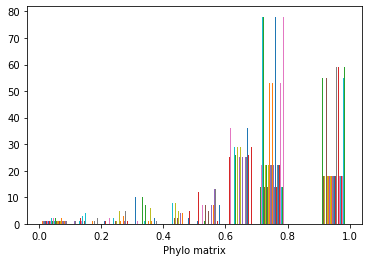

In [23]:
plt.hist(Pmat)
plt.xlabel('Phylo matrix');

In [24]:
Body

['elongate', 'short_deep', 'fusiform', 'flat']

In [25]:
Habitat

['pelagic_oceanic',
 'benthopelagic',
 'pelagic_neritic',
 'demersal',
 'reef_associated']

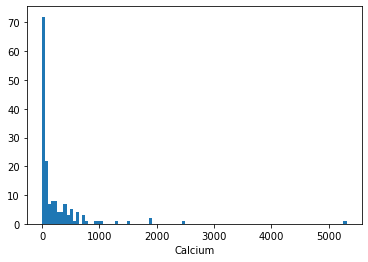

In [26]:
plt.hist(Y,bins=100)
plt.xlabel(nut);

In [27]:
len(Isp),max(Isp), Pmat.shape

(158, 78, (79, 79))

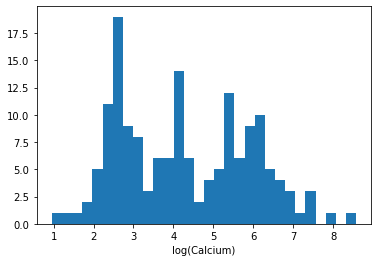

In [28]:
plt.hist(Ylog,bins=30)
plt.xlabel('log('+nut+')');

## Specify models

In [29]:
# Custom function 
class LinearMean(pm.gp.mean.Mean):
    def __init__(self, b0, b1, b2, b3, b4, b5, b6, b7, b8, b9):
        self.b0 = b0
        self.b1 = b1
        self.b2 = b2
        self.b3 = b3
        self.b4 = b4
        self.b5 = b5
        self.b6 = b6
        self.b7 = b7
        self.b8 = b8
        self.b9 = b9

    def __call__(self, X):
        """Where do the covariates come from?"""
        return self.b0+self.b1+self.b2+self.b3*MaxDepth+self.b4*TL+self.b5+self.b6*LMax+self.b7+self.b8*K+self.b9*tm

In [55]:
?pm.gp.cov.Exponential

In [30]:
with pm.Model() as Phylo_GP:
    ## Species level parameters
    # Intercept
    β0 = pm.Normal('Intercept', 0, 1)
    # Habitat type
    β1 = pm.Normal('Habitat', 0, 1, shape=nhabs)
    # Climate
    β2 = pm.Normal('Climate', 0, 1, shape=nclim)
    # Maximum Depth
    β3 = pm.Normal('MaxDepth', 0, 1)
    # Total Length
    β4 = pm.Normal('TL', 0, 1)
    # Pelagic/demersal
    β5 = pm.Normal('FeedPath', 0, 1, shape=nfp)
    # Maximum length
    β6 = pm.Normal('LMax', 0, 1)
    # Body form
    β7 = pm.Normal('Body', 0, 1, shape=nbod)
    # Growth parameter
    β8 = pm.Normal('K', 0, 1)
    # Age at maturity
    β9 = pm.Normal('tm', 0, 1)
    # Linear model for each species
    mu = LinearMean(β0,β1[Ih],β2[Ic],β3,β4,β5[Ifp],β6,β7[Ib],β8,β9)
    
    # half_normal(1, 0.25) is too strong
    etasq = pm.Exponential("etasq", .25)
    rhosq = pm.Normal("rhosq", 3, .25)
    #etasq = pm.Normal("etasq", 1.0, 0.25)
    
    # specify the covariance function:
    cov = etasq * pm.gp.cov.Exponential(input_dim=nspp, ls=rhosq)
    
    
    gp = pm.gp.Latent(mean_func=mu, cov_func=cov)
    # Species-level intercepts
    μ0 = gp.prior("μ0", X=Pmat)
    
    ## Observation level nussiance parameters
    # Form of sample
    μ1 = pm.Normal('Form', 0, 1, shape=nform)
    # Form of prepartion
    μ2 = pm.Normal('Prep', 0, 1, shape=nprep)
    # Database used
    μ3 = pm.Normal('Search', 0, 1, shape=nsearch)
    # Observation model
    μ_ = μ0[Isp]+μ1[If]+μ2[Ip]+μ3[Is]
    
    
    # Gamma model
    μ = tt.exp(μ_)
    α = pm.Gamma('α', 2, 2)
    Yi = pm.Gamma('Yi', alpha=α, beta=α/μ, observed=Ylog)

In [31]:
for RV in Phylo_GP.basic_RVs:
    print(RV.name, RV.logp(Phylo_GP.test_point))

Intercept -0.9189385332046727
Habitat -4.594692666023363
Climate -3.6757541328186907
MaxDepth -0.9189385332046727
TL -0.9189385332046727
FeedPath -1.8378770664093453
LMax -0.9189385332046727
Body -3.6757541328186907
K -0.9189385332046727
tm -0.9189385332046727
etasq_log__ -1.0596601002984287
rhosq 0.4673558279152179
μ0_rotated_ -72.59614412316915
Form -3.6757541328186907
Prep -2.756815599614018
Search -2.756815599614018
α_log__ -0.6137056388801094
Yi -677.1580762647557


In [32]:
# Sampling
with Phylo_GP:
    # Draw samples
    trace_Phylo_GP = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, Search, Prep, Form, μ0_rotated_, rhosq, etasq, tm, K, Body, LMax, FeedPath, TL, MaxDepth, Climate, Habitat, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 607 seconds.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [33]:
pm.waic(trace_Phylo_GP, scale='deviance')

/Users/aaronmacneil/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/aaronmacneil/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:1413: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 4000 by 158 log-likelihood matrix

              Estimate       SE
deviance_waic   467.62    20.85
p_waic           24.19        -

There has been a warning during the calculation. Please check the results.

The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if
you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive
accuracy.

In [34]:
Phylo_GP_posterior = az.from_pymc3(trace_Phylo_GP)

In [53]:
# Export results 
out = pm.backends.tracetab.trace_to_dataframe(trace_Phylo_GP)
colnames = np.array(list(out.columns), dtype=object)
# Rename columns
colnames[match(grep('Habitat',list(colnames)),list(colnames))] = Habitat
colnames[match(grep('Climate',list(colnames)),list(colnames))] = Climate
colnames[match(grep('Body',list(colnames)),list(colnames))] = Body
colnames[match(grep('Form',list(colnames)),list(colnames))] = Form
colnames[match(grep('Prep',list(colnames)),list(colnames))] = Prep
colnames[match(grep('Search',list(colnames)),list(colnames))] = Search
# Rename
out.columns = list(colnames)

In [54]:
out.to_csv(nut+'_results.csv')

In [35]:
#az.summary(Phylo_GP_posterior, round_to=2)

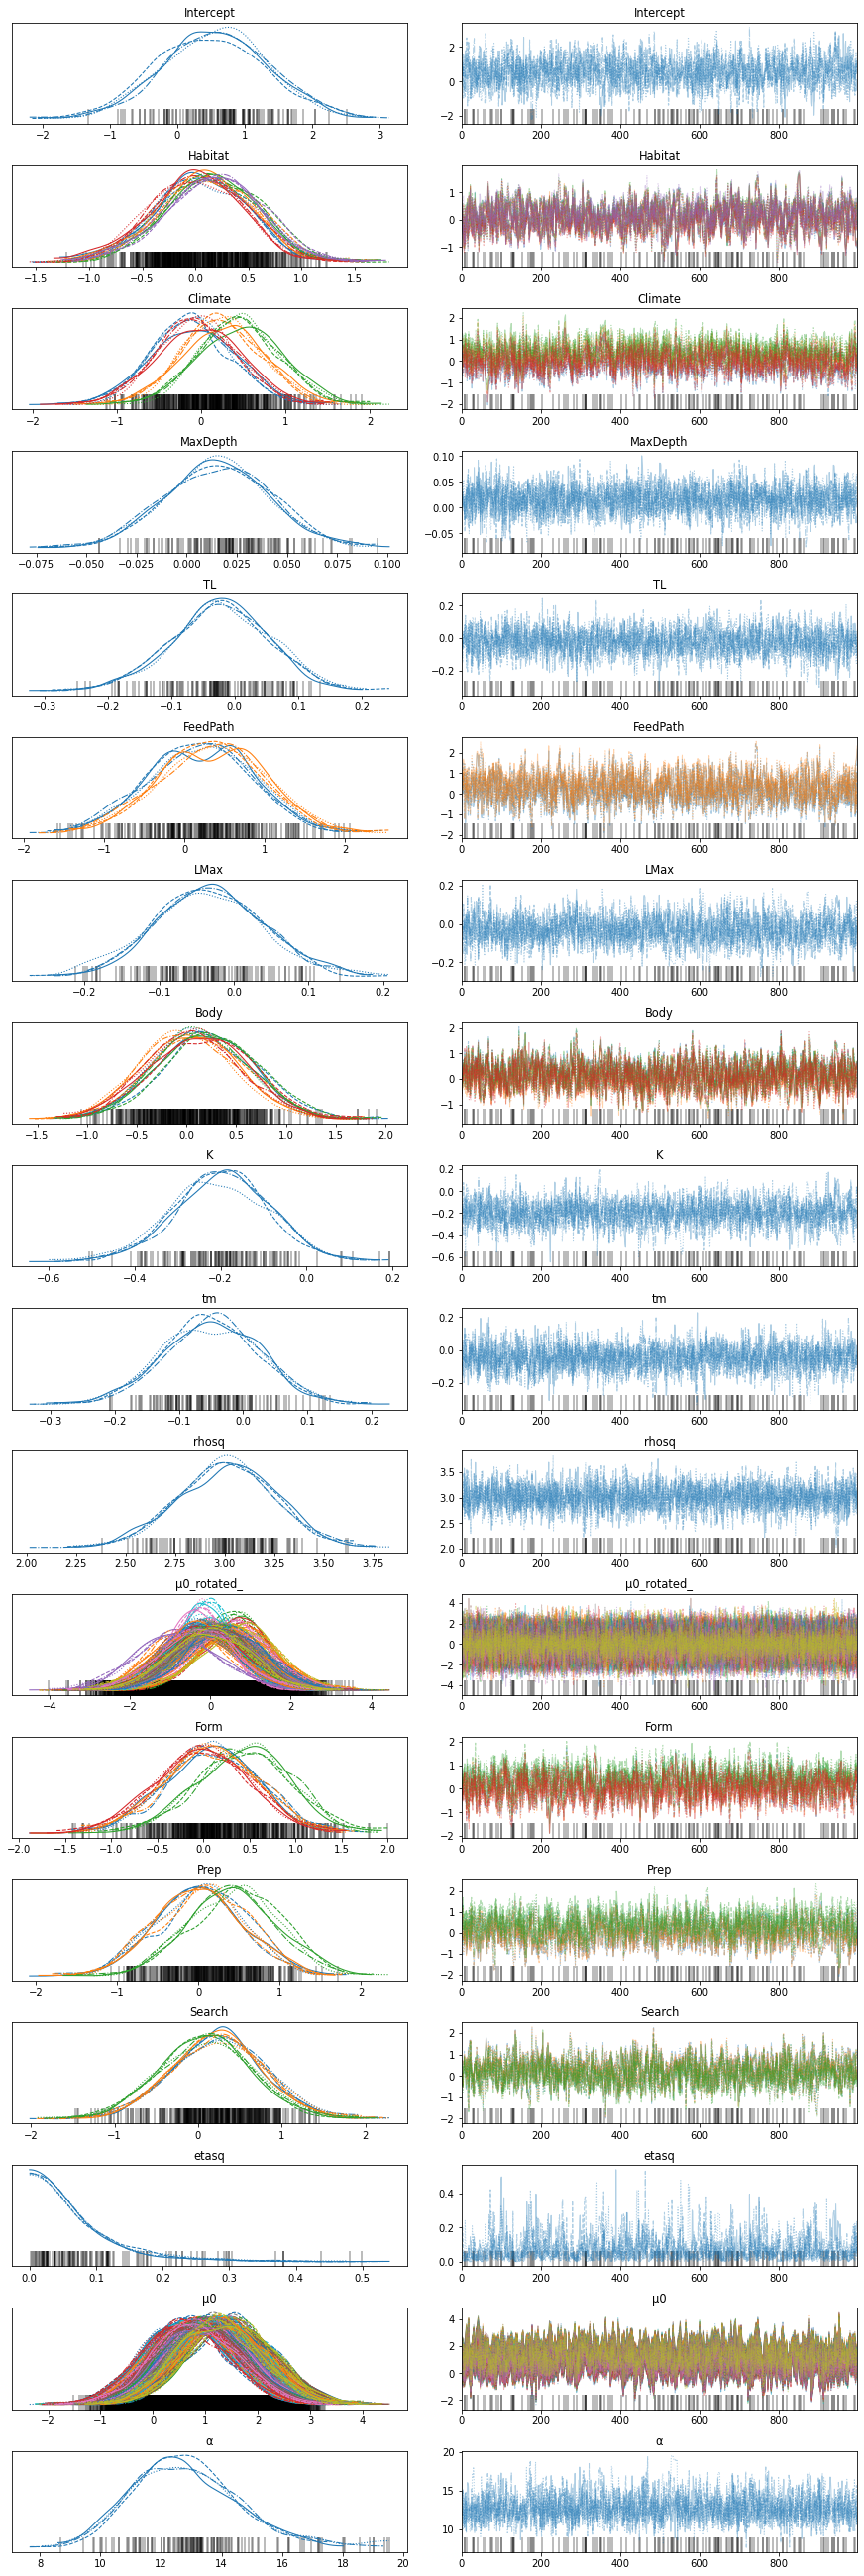

In [36]:
az.plot_trace(Phylo_GP_posterior, compact=True);

/Users/aaronmacneil/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:483: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/Users/aaronmacneil/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:483: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


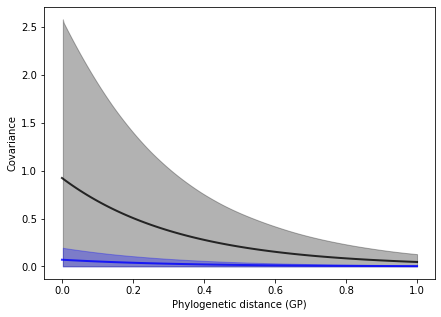

In [37]:
d_seq = np.linspace(0, Pmat.max(), 100)
post = Phylo_GP_posterior.posterior.stack(sample=("chain", "draw"))

_, ax = plt.subplots(1, 1, figsize=(7, 5))

# prior mean and 89% interval
eta = np.random.exponential(1.0, 1000)
rho = np.random.normal(3.0, 0.25, 1000)
Kx = []
for d in d_seq:
    Kx.append(eta * np.exp(-rho * d))
Kx = np.asarray(Kx)

ax.plot(d_seq, Kx.mean(1), "k", alpha=.8, lw=2)
az.plot_hdi(d_seq, Kx.T, color="k", fill_kwargs={"alpha": .3}, ax=ax)

# posterior
#indx = np.random.choice(1000, 50)
#post_etasq = post["etasq"].values[indx][:, None]
#post_rhosq = post["rhosq"].values[indx][:, None]
#ax.plot(d_seq, (post_etasq * np.exp(-post_rhosq * d_seq)).T, "b", alpha=0.1)
#ax.plot(d_seq, (post["etasq"].median().values * np.exp(-post["rhosq"].median().values * d_seq)), c='b')
Kp = []
for d in d_seq:
    Kp.append(post["etasq"].values * np.exp(-post["rhosq"].values * d))
Kp = np.asarray(Kp)

ax.plot(d_seq, Kp.mean(1), "b", alpha=.8, lw=2)
az.plot_hdi(d_seq, Kp.T, color="b", fill_kwargs={"alpha": .3}, ax=ax)


ax.set(xlabel="Phylogenetic distance (GP)", ylabel="Covariance")
plt.savefig('GP_calcium_PriorPost.jpg');

/Users/aaronmacneil/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


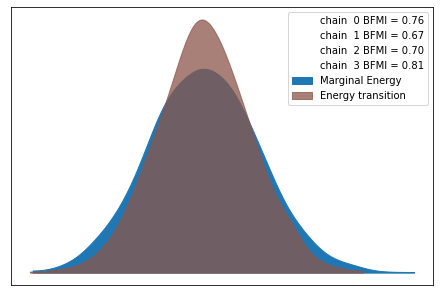

In [38]:
pm.plots.energyplot(trace_Phylo_GP);

In [39]:
with pm.Model() as Hicks:
    # Intercept
    γ0 = pm.Normal('Intercept', 0, 5)
    # Observation model
    #σγ = pm.Uniform('Sigma_γ', 0, 100)
    #β0 = pm.Normal('Order', mu=γ0, sd=σγ, shape=nord)
    #pi_tilde = pm.Normal('pi_t', 0, 1, shape=nord)
    #β0 = pm.Deterministic('Order', γ0 + σγ*pi_tilde)
    # Random effect of data-source
    #β01 = pm.Normal('Geography', 0, 1, shape=ngeo)
    
    #"""
    # Habitat type
    β1 = pm.Normal('Habitat', 0, 1, shape=nhabs)
    # Climate
    β2 = pm.Normal('Climate', 0, 1, shape=nclim)
    # Maximum Depth
    β3 = pm.Normal('MaxDepth', 0, 1)
    # Total Length
    β4 = pm.Normal('TL', 0, 1)
    # Pelagic/demersal
    β5 = pm.Normal('FeedPath', 0, 1, shape=nfp)
    # Maximum length
    β6 = pm.Normal('LMax', 0, 1)
    # Body form
    β7 = pm.Normal('Body', 0, 1, shape=nbod)
    # Growth parameter
    β8 = pm.Normal('K', 0, 1)
    # Age at maturity
    β9 = pm.Normal('tm', 0, 1)
    
    # Form of sample
    β10 = pm.Normal('Form', 0, 1, shape=nform)
    # Form of prepartion
    β11 = pm.Normal('Prep', 0, 1, shape=nprep)
    # Database used
    β12 = pm.Normal('Search', 0, 1, shape=nsearch)
    
    #"""
    
    # Mean model
    mu = γ0+β1[Ih]+β2[Ic]+β3*MaxDepth+β4*TL+β5[Ifp]+β6*LMax+β7[Ib]+β8*K+β9*tm
    
    # Observation model
    μ_ = mu[Isp]+β10[If]+β11[Ip]+β12[Is]
    
    # Gamma model
    μ = tt.exp(μ_)
    α = pm.Gamma('α', 2, 2)
    Yi = pm.Gamma('Yi', alpha=α, beta=α/μ, observed=Ylog)

In [40]:
for RV in Hicks.basic_RVs:
    print(RV.name, RV.logp(Hicks.test_point))

Intercept -2.528376445638773
Habitat -4.594692666023363
Climate -3.6757541328186907
MaxDepth -0.9189385332046727
TL -0.9189385332046727
FeedPath -1.8378770664093453
LMax -0.9189385332046727
Body -3.6757541328186907
K -0.9189385332046727
tm -0.9189385332046727
Form -3.6757541328186907
Prep -2.756815599614018
Search -2.756815599614018
α_log__ -0.6137056388801094
Yi -677.1580762647557


In [41]:
# Sampling
with Hicks:
    # Draw samples
    trace_Hicks = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, Search, Prep, Form, tm, K, Body, LMax, FeedPath, TL, MaxDepth, Climate, Habitat, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 116 seconds.
There were 64 divergences after tuning. Increase `target_accept` or reparameterize.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
There were 125 divergences after tuning. Increase `target_accept` or reparameterize.
There were 81 divergences after tuning. Increase `target_accept` or reparameterize.


/Users/aaronmacneil/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


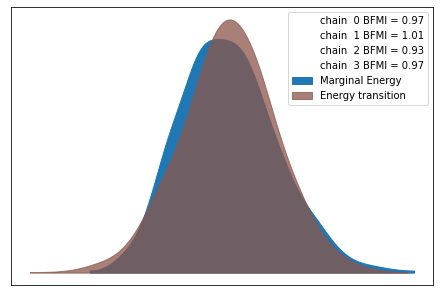

In [42]:
pm.plots.energyplot(trace_Hicks);

In [43]:
pm.waic(trace_Hicks, scale='deviance')

/Users/aaronmacneil/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/aaronmacneil/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:1413: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 4000 by 158 log-likelihood matrix

              Estimate       SE
deviance_waic   473.26    21.69
p_waic           17.75        -

There has been a warning during the calculation. Please check the results.

The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if
you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive
accuracy.

In [44]:
Hicks_posterior = az.from_pymc3(trace_Hicks)

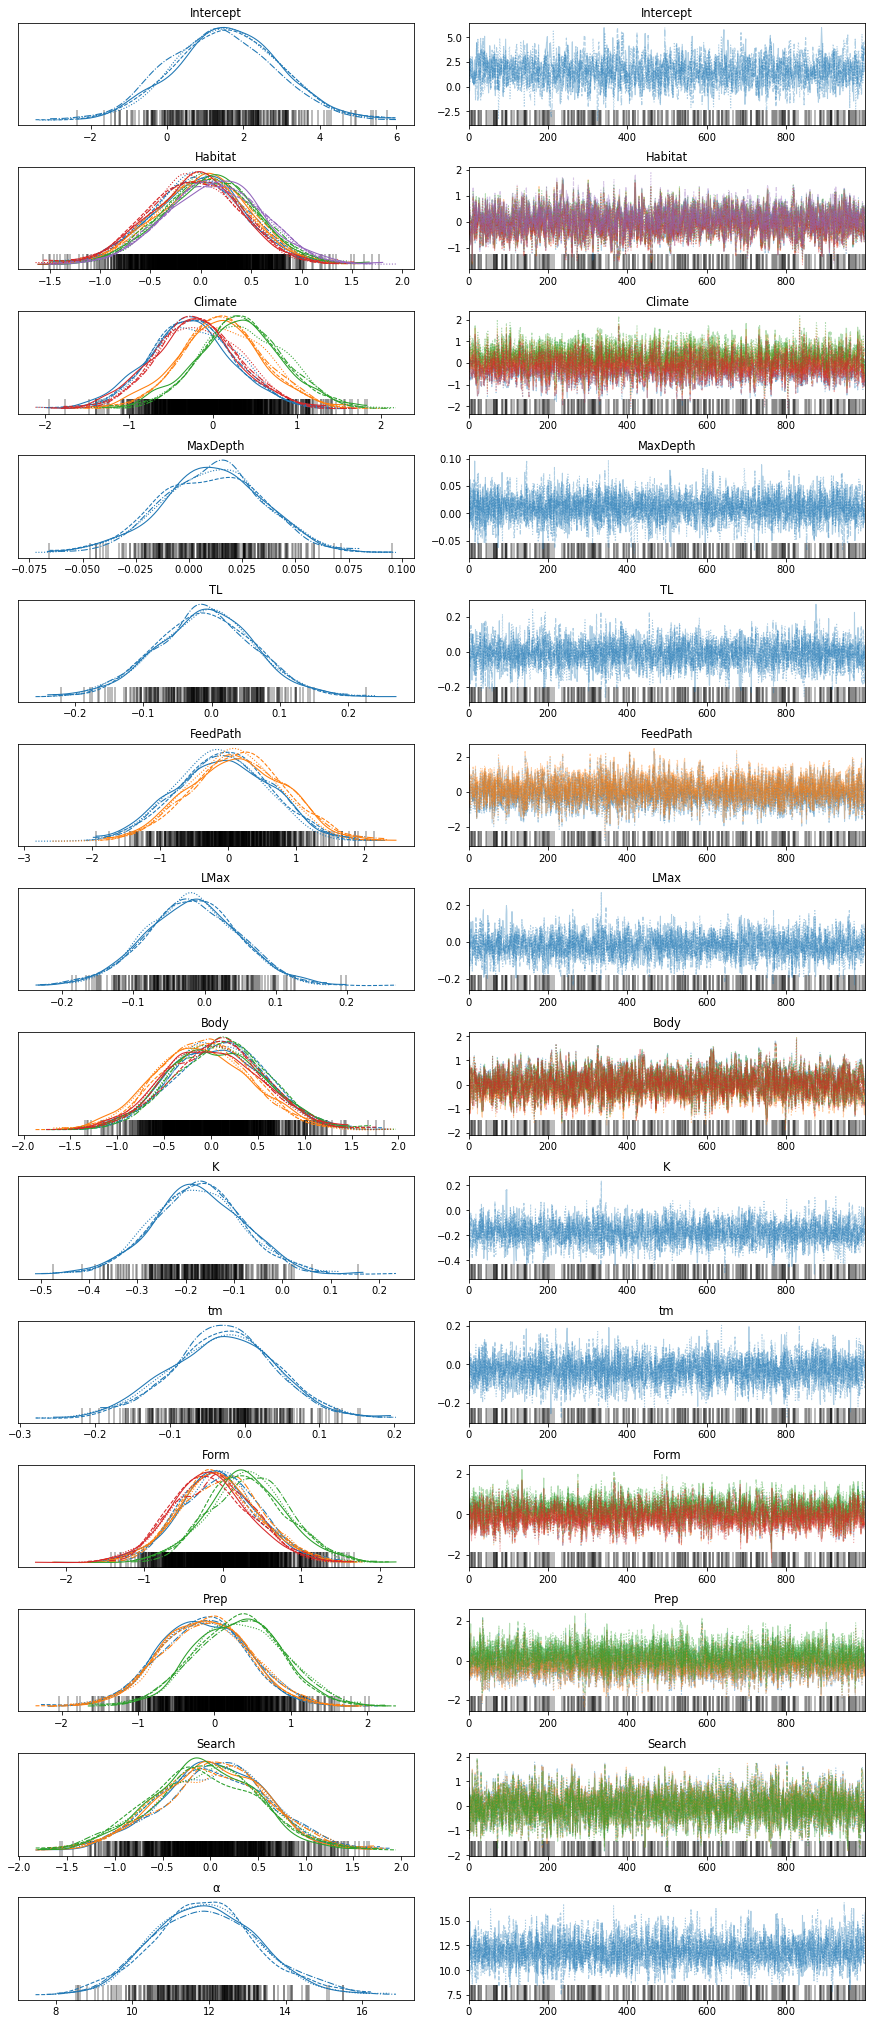

In [45]:
az.plot_trace(Hicks_posterior, compact=True);

In [46]:
model_compare = az.compare({'Hicks':trace_Hicks,'Phylogenetic':trace_Phylo_GP}, scale='deviance')
model_compare

/Users/aaronmacneil/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/aaronmacneil/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:682: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/aaronmacneil/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future r

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
Phylogenetic,0,471.945,26.347,0,0.751385,21.9208,0,True,deviance
Hicks,1,474.954,18.6026,3.00963,0.248615,21.7558,2.74578,True,deviance


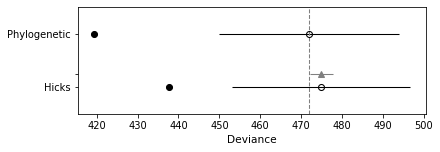

In [47]:
az.plot_compare(model_compare)